# Import necessary libraries



In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK resources


In [25]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NTC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NTC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True





# Load the dataset


In [26]:
data = pd.read_csv("C:\\Users\\NTC\\Downloads\\Youtube_comments.csv")

C:\Users\NTC\AppData\Local\Temp\ipykernel_476\2893438889.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\\Users\\NTC\\Downloads\\Youtube_comments.csv")



# Preprocessing: Cleanse and preprocess the comments



In [27]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Compile regular expression pattern for URLs, mentions, and hashtags
url_pattern = re.compile(r'http\S+|www\S+|https\S+')
mention_hashtag_pattern = re.compile(r'\@\w+|\#')

# Set of English stopwords for faster lookups
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, mentions, and hashtags
    text = url_pattern.sub('', text)
    text = mention_hashtag_pattern.sub('', text)
    # Remove special characters and numbers, tokenize text
    text = word_tokenize(re.sub(r'[^A-Za-z0-9]+', ' ', text))
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)


# Apply preprocessing to the 'comment_text' column
data['cleaned_comment'] = data['comment_text'].apply(preprocess_text)


# Sentiment Analysis


In [28]:
analyzer = SentimentIntensityAnalyzer()


def sentiment_analysis(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'


data['sentiment'] = data['cleaned_comment'].apply(sentiment_analysis)


# Sentiment distribution per video


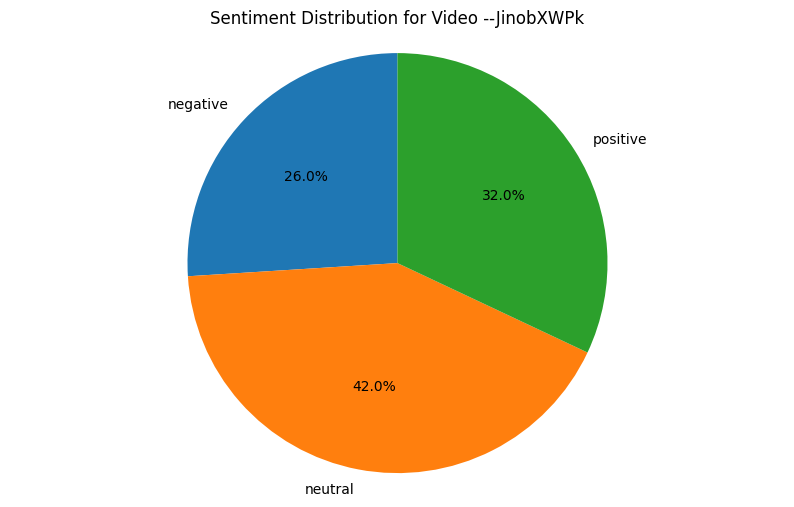

In [42]:
# Group data by video_id and sentiment, then unstack and fill NaN with 0
sentiment_distribution = data.groupby(
    ['video_id', 'sentiment']).size().unstack().fillna(0)

# Calculate the total number of comments per video
total_comments_per_video = sentiment_distribution.sum(axis=1)

# Plot a pie chart for each video
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Set colors for pie chart slices

for i, video_id in enumerate(sentiment_distribution.index):
    sizes = sentiment_distribution.loc[video_id].values
    labels = sentiment_distribution.columns
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',
           startangle=90, colors=colors)
    ax.set_title(f'Sentiment Distribution for Video {video_id}')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()



# Topic Modeling


In [30]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(data['cleaned_comment'])

# Using LDA for topic modeling


In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Optimize vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english',
                                   use_idf=True, smooth_idf=True, sublinear_tf=False)
tfidf = tfidf_vectorizer.fit_transform(data['cleaned_comment'])

# Reduce the number of components (topics)
n_topics = 5

# Utilize parallelization
lda = LatentDirichletAllocation(
    n_components=n_topics, random_state=42, n_jobs=-1)

# Fit LDA model
lda.fit(tfidf)



LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=42)

# Displaying the topics


In [37]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i]
              for i in topic.argsort()[:-num_top_words - 1:-1]]))


display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic #0:
video amazing like good love cute great cool really lol
Topic #1:
love wow awesome video like hair perfect make music look
Topic #2:
trending people beautiful trump fuck god like nice white video
Topic #3:
song love omg like yes shit great voice video good
Topic #4:
movie like iphone na wtf wait gon watch trailer know






# Engagement Metrics


In [51]:
# need to work on it 

# Visualization and Reporting
Word Cloud


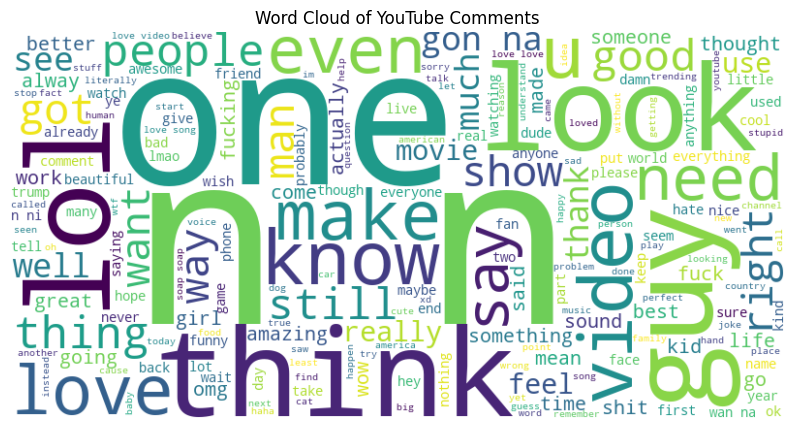

In [45]:
all_comments = ' '.join(data['cleaned_comment'])
wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(all_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of YouTube Comments')
plt.show()



# Sentiment distribution plot


C:\Users\NTC\AppData\Local\Temp\ipykernel_476\2659464722.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index,


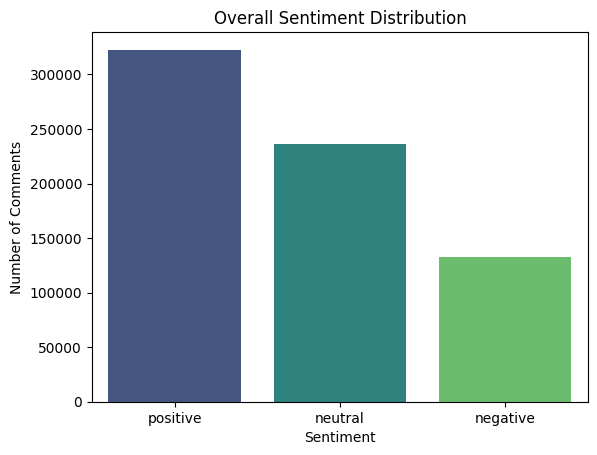

In [47]:
sentiment_counts = data['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index,
            y=sentiment_counts.values, palette='viridis')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

# Summary report

In [54]:
# related to Engagement Metrics that I need to work on it 
#summary_report = engagement_metrics.describe()
#print(summary_report)

# Save the results to a CSV file
data.to_csv('processed_youtube_comments.csv', index=False)